In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

     |████████████████████████████████| 184kB 4.2MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212938 sha256=f2ab8a2178213787febf755ff77d36fa6e7632f2dd56f5742485b2934d870155
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


In [ ]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'hsdata')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((610, 340, 103), (610, 340))

In [ ]:
one_hot.shape

(144, 144, 17)

In [ ]:
n_classes = 10
one_hot = np.zeros((144, 144, n_classes))
for i, unique_value in enumerate(np.unique(y)):
    one_hot[:, :, i][y == unique_value] = 1

In [ ]:
K = 30 if dataset == 'IP' else 30
X,pca = applyPCA(X,numComponents=K)

X.shape

(144, 144, 30)

In [ ]:
import cv2
X = cv2.resize(X,(144,144))
X.shape

(144, 144, 103)

In [ ]:
import cv2
y = cv2.resize(y,(144,144))
y.shape

(144, 144)

In [ ]:
y = one_hot.reshape(1, 144, 144, 10)

In [ ]:
import cv2
X_r = cv2.resize(X,(144,144))
X_r.shape

(144, 144, 30)

In [ ]:
X_r = X.reshape(-1, 144, 144, 30, 1)

In [ ]:
import os
import tensorflow as tf
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling3D, Conv3DTranspose, Flatten, Dense, BatchNormalization
from keras.layers.core import Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
def get_model():
    inputs = Input((144, 144, 30, 1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    # conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1) #84

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    # conv2 = BatchNormalization()(conv2)
    # conv2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2) #42

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    # conv3 = BatchNormalization()(conv3)
    # conv3 = Dropout(0.1)(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3) #21

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    # conv4 = BatchNormalization()(conv4)
    # conv4 = Dropout(0.1)(conv4)
    # pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4) #7

    # conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    # conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)
#     conv5 = BatchNormalization()(conv5)
#     conv5 = Dropout(0.2)(conv5)
    #pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
#     conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
#     conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv6)
    
    flat6 = Flatten()(conv4)
    output_1 = Dense(9, activation='softmax', name='output_1')(flat6)

#     up7 = concatenate([Conv2DTranspose(512, (2, 2), padding='same')(conv6), conv5], axis=3)
#     conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
#     conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)
    
    # up8 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=3)
    # conv8 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up8)
    # conv8 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv8)
#     conv8 = BatchNormalization()(conv8)
#     conv8 = Dropout(0.2)(conv8)

    up9 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4), conv3], axis=3)
    conv9 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv9)
    # conv9 = BatchNormalization()(conv9)
    # conv9 = Dropout(0.1)(conv9)

    up10 = concatenate([Conv3DTranspose(64, (2, 2,2 ), strides=(2, 2, 2), padding='same')(conv9), conv2], axis=3)
    conv10 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv10)
    # conv10 = BatchNormalization()(conv10)
    # conv10 = Dropout(0.1)(conv10)

    up11 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2,2, 2), padding='same')(conv10), conv1], axis=3)
    conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv11)

    conv3d_shape = conv11.shape

    conv11 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv11)

    output_2 = Conv2D(10, (1, 1), activation='softmax', name='output_2')(conv11)

    model = Model(inputs=[inputs], outputs=[ output_2])

    model.compile(optimizer=Adam(lr=0.001), loss={'output_2': 'categorical_crossentropy'}, metrics=[tf.keras.metrics.MeanIoU(num_classes=17)])

    return model

In [ ]:
model = get_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 144, 144, 30 0                                            
__________________________________________________________________________________________________
conv3d_28 (Conv3D)              (None, 144, 144, 30, 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv3d_29 (Conv3D)              (None, 144, 144, 30, 27680       conv3d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_6 (MaxPooling3D)  (None, 72, 72, 15, 3 0           conv3d_29[0][0]                  
____________________________________________________________________________________________

In [ ]:
model.fit(x=X_r, y=y, batch_size=1, epochs=100) #400

Epoch 1/100
1/1 [==============================] - 1s 631ms/step - loss: 0.0507 - mean_io_u_1: 0.4813
Epoch 2/100
1/1 [==============================] - 1s 628ms/step - loss: 0.0461 - mean_io_u_1: 0.4788
Epoch 3/100
1/1 [==============================] - 1s 628ms/step - loss: 0.0443 - mean_io_u_1: 0.4816
Epoch 4/100
1/1 [==============================] - 1s 631ms/step - loss: 0.0394 - mean_io_u_1: 0.4911
Epoch 5/100
1/1 [==============================] - 1s 628ms/step - loss: 0.0361 - mean_io_u_1: 0.4876
Epoch 6/100
1/1 [==============================] - 1s 629ms/step - loss: 0.0325 - mean_io_u_1: 0.4943
Epoch 7/100
1/1 [==============================] - 1s 627ms/step - loss: 0.0299 - mean_io_u_1: 0.5065
Epoch 8/100
1/1 [==============================] - 1s 627ms/step - loss: 0.0271 - mean_io_u_1: 0.5010
Epoch 9/100
1/1 [==============================] - 1s 629ms/step - loss: 0.0243 - mean_io_u_1: 0.5076
Epoch 10/100
1/1 [==============================] - 1s 628ms/step - loss: 0.0227 -

In [ ]:
#Iterations - 400  loss - 0.0940  accuracy - 0.9735 - V1
#Iterations - 400  loss - 0.0698  mean_io_u_1 - 0.5650 (0.6999816) - V2
#Iterations - 400

In [ ]:
y_pred = model.predict(X_r)

In [ ]:
mask_pred = np.zeros((144, 144))
for i in range(144):
  for j in range(144):
    index = np.argmax(y_pred[0][i][j])
    if y_pred[0][i][j][index]<0.85:
      mask_pred[i][j] = 0
    else:
      mask_pred[i][j] = np.argmax(y_pred[0][i][j])

In [ ]:
X_k, y_truth = loadData(dataset)

y_truth.shape
y_truth = cv2.resize( y_truth, (144, 144))

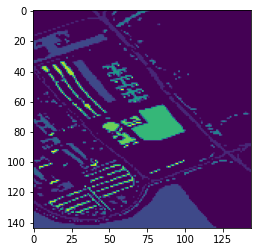

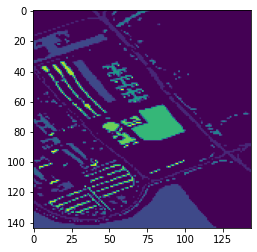

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(y_truth)
plt.show()
plt.imshow(mask_pred)
plt.show()

In [ ]:
model.save('3DUnet_v2.hdf5')

In [ ]:
intersection = np.logical_and(y_truth, mask_pred)
union = np.logical_or(y_truth, mask_pred)
iou_score = np.sum(intersection) / np.sum(union)

In [ ]:
iou_score

0.8035206258890469